# 1. Loading Libraries and Data


In [ ]:
!pip install -q transformers tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.1 MB/s eta 0:00:00


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import drive
import os
import re
import string
import gc
import sys

from tqdm.notebook import tqdm

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV, train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical

from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import transformers
from transformers import (AutoTokenizer, AutoModel, AdamW, AutoConfig, get_linear_schedule_with_warmup)

In [ ]:
import locale
print(locale.getpreferredencoding())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

UTF-8


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI 891 NLP/"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
['Copy of MMAI 891 NLP Project ZINDI Transformes.ipynb', 'Project Brief - Zindi Classification.docx', 'Test.csv', 'Train.csv', 'SampleSubmission.csv', 'NLP_Primer_twitter_challenge.ipynb', 'MMAI 891 NLP Project ZINDI Shallow ML.ipynb', 'MMAI 891 NLP Project ZINDI Deep Learning.ipynb', 'Bert_results.csv', 'Bert_model-1.h5', 'test_predictions.csv', 'Bert_results2.csv', 'MMAI 891 NLP Project ZINDI Transformes.ipynb', 'ToVaccineOrNotToVaccine-master']
/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP


In [ ]:
# Load the data
train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data
test = pd.read_csv('Test.csv').fillna('') # Read in test
test['label']=0 # We'll fill this in with predictions later
train.head() # Take a peek at the data

# tsv_data.drop_duplicates(subset="SentenceId", keep="first", inplace=True)

<ipython-input-10-16aca962e813>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [ ]:
test.isnull().sum()

tweet_id     0
safe_text    0
label        0
dtype: int64

In [ ]:
train['label'].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [ ]:
print('The train set has', train.shape,'entries', 'and test set has', test.shape)

The train set has (9999, 4) entries and test set has (5177, 3)


In [ ]:
train.shape[0]

9999

In [ ]:
len(train['label'].unique())

3

In [ ]:
train_df = train.copy()
test_df = test.copy()

In [ ]:
validation_df = pd.DataFrame(train_test_split(train_df, test_size=0.1, random_state=17, shuffle=True))

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [ ]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
print(train_df["label"].isnull().sum())

0


In [ ]:
seqlen = train_df["safe_text"].apply(lambda x: len(x.split()))
print(seqlen.shape)
print('The maximum sequense lengt is:', max(seqlen))

(9999,)
The maximum sequense lengt is: 33


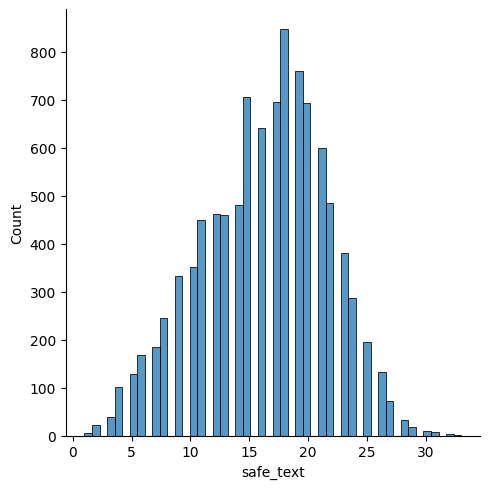

<Figure size 3000x1500 with 0 Axes>

In [ ]:
sns.displot(seqlen)

sns.set_style("darkgrid")
plt.figure(figsize=(30, 15))
plt.show()

# Utilities

In [ ]:
def process_prediction(preds):
  r'''
    This function helps us go from a classifiaction
    problem to a regression one.
    The regression values range are in [-1, 1].
  '''

  final_preds = []
  for pred in preds:
    argmax = np.argmax(pred, axis=0)
    if argmax == 0: final_preds.append( -1*pred[0] )
    elif argmax == 1: final_preds.append( 0 )
    else: final_preds.append( pred[2] )
    
  return final_preds


def rmse(true, pred):
  return np.sqrt(mean_squared_error(true, pred))

# Transfer

In [ ]:
# The maximum seqlen is 33 so 50makes sense to consider as the maximum sequense length for this project. 
SEQ_LEN = 50

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokens = tokenizer.encode_plus("You dumb fuck", max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )

tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101,  1192, 14908,  9367,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
Xids = np.zeros((len(train_df), SEQ_LEN))
Xmask = np.zeros((len(train_df), SEQ_LEN))

Xids.shape, Xmask.shape

((9999, 50), (9999, 50))

In [ ]:
# Make sure you identify the text part of the input as 'text'
def encode_text(text, SEQ_LEN):
  Xids = np.zeros((len(text), SEQ_LEN))
  Xmask = np.zeros((len(text), SEQ_LEN))
  for i, sequence in enumerate(text):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]
  return Xids, Xmask

train_Xids, train_Xmask = encode_text(train_df['safe_text'], SEQ_LEN)
test_Xids, test_Xmask = encode_text(test_df['safe_text'], SEQ_LEN)

# train_Xids[0]

In [ ]:
for i, sequence in enumerate(train_df["safe_text"]):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]

In [ ]:
train_Xids[0]

array([  101.,  2508.,   111.,  1821.,  1643.,   132.,  1109.,  2562.,
        9800.,  9745.,  1928.,  9858., 13144.,  7629.,   108., 22157.,
       14962., 23904.,  3663.,   108., 19443.,   108., 19443.,  1708.,
         108.,   150., 21148.,   108., 23676., 17020.,  8271., 20734.,
       15499.,  2036.,   137.,  1457., 12606.,  1399.,  1457.,   119.,
         133.,   190., 17670.,   135.,   102.,     0.,     0.,     0.,
           0.,     0.])

In [ ]:
train_df["label"].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [ ]:
# # Map the labels to 0, 1, 2 to have them all integers
# value_map = {-1: 0, 0: 1, 1: 2}
# input_list = train_df["label"]
# output_list = [value_map[x] for x in input_list]
# print(output_list)
# train_df["label"] = output_list

In [ ]:
# train_df["label"] = output_list

In [ ]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
arr = train_df["label"].values
labels = np.zeros((arr.size, arr.max()+1))

labels[np.arange(arr.size), arr] = 1
labels

labels

TypeError: ignored

In [ ]:
tf.config.experimental.list_logical_devices("GPU")

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
train_Xids.shape, train_Xmask.shape, labels.shape

((9999, 50), (9999, 50), (9999, 3))

In [ ]:
# make a tensor dataset for the model
dataset = tf.data.Dataset.from_tensor_slices((train_Xids, train_Xmask, labels))

In [ ]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [ ]:
dataset = dataset.map(map_func)

for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,  2508.,   111.,  1821.,  1643.,   132.,  1109.,  2562.,
        9800.,  9745.,  1928.,  9858., 13144.,  7629.,   108., 22157.,
       14962., 23904.,  3663.,   108., 19443.,   108., 19443.,  1708.,
         108.,   150., 21148.,   108., 23676., 17020.,  8271., 20734.,
       15499.,  2036.,   137.,  1457., 12606.,  1399.,  1457.,   119.,
         133.,   190., 17670.,   135.,   102.,     0.,     0.,     0.,
           0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 1., 0.])>)


In [ ]:
dataset = dataset.shuffle(1000000).batch(32)

In [ ]:
DS_LEN = len(dataset)

In [ ]:
SPLIT = 0.9

train_data = dataset.take(round(DS_LEN * SPLIT))
val_data = dataset.skip(round(DS_LEN * SPLIT))

del dataset

In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 50), dtype=tf.float64, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
params = {
          'RANDOM_STATE': 17,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'tanh',
          'DROPOUT_RATE':0.2,
          'LEARNING_RATE': 1e-4,
          'LEARNING_RATE_DECAY':False,
          'CHECKPOINT':True,
          'EPOCHS':100,
          'NUM_CLASSES': len(train['label'].unique()),
          'max_seq_len': 50
}

https://www.kaggle.com/code/anshalsingh/sentiment-analysis

# 4. Basic Model

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0, max_iter=1000, multi_class='auto')
scores = model_selection.cross_val_score(clf, train_vectors, train_df["label"], cv=5)
scores

array([0.7065    , 0.7245    , 0.7295    , 0.7265    , 0.71585793])

In [ ]:
clf.fit(train_vectors, train_df["label"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


LogisticRegression(max_iter=1000, verbose=1)

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0, max_iter=1000, multi_class='auto')
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train_df["label"], cv=5)
scores

array([0.721     , 0.74      , 0.7315    , 0.7325    , 0.71935968])